In [315]:
import numpy as np
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
from scipy import optimize
from pandas import DataFrame
import math
import scipy.optimize as opt

data = np.loadtxt("./data/2_source.csv",delimiter=",")   
data = np.array(data)

%matplotlib inline

In [316]:
angle_step = 15
angles=np.arange(0,len(data)*angle_step,angle_step)
print('Angles:',angles)

Angles: [ 0 15 30 45 60 75 90]


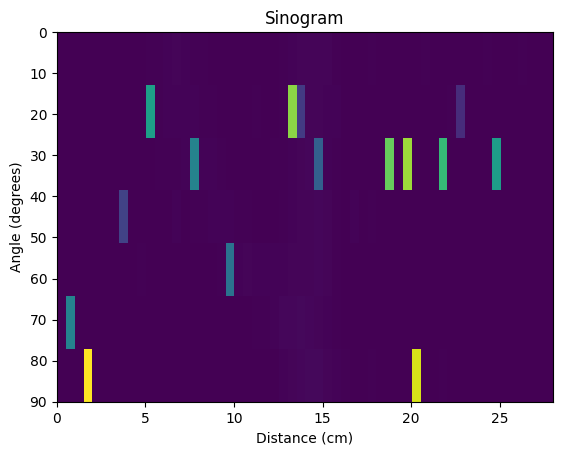

In [317]:
fig,ax = plt.subplots()
start_dist = 0
end_dist = 28
start_angle = 0
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.set_title("Sinogram");

In [318]:
from scipy import ndimage
expand_vec = np.ones(data2[0].size)  # this is used to get us a square matrix
expanded_data = []
for item in data:
    expanded_data.append(np.outer(expand_vec,item))

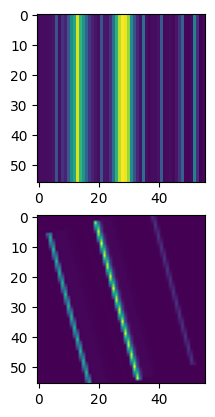

In [319]:
rotated_data = []
for index, item in enumerate(expanded_data):
    rotated_data.append(ndimage.rotate(item,angles[index],reshape=False,order=1)) # we want Numpy to keep our square, 2d matricies.
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(rotated_data[0])
ay.imshow(rotated_data[1])


To do this, we'll make a composite image by multiplying each of these expanded & rotated slices together.  Locations where we don't see many coincidences at any angle will end up with low counts, and locations with lots of coincidences at similar angles will end up with high counts.  It may be easier to see what this looks like, so let's start by recombining just the first and third slices.

We'll also normalize the data by taking the `nth` root, where `n` is the number of slices we're using.  The units would end up being something insane if we didn't do this.

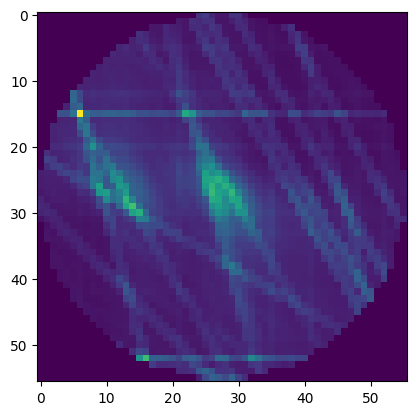

In [320]:
composite = np.ones_like(rotated_data[0])
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)

Clearly, the composite images will hardly give us any good idea of what is going on in the blackbox. 

# Filtering Rotate Data

In [306]:
def n_avg(list, i, j):
    sum = 0
    div = 0
    for offset_i in [-1,0, 1]:
        for offset_j in [-1,0, 1]:
            new_i = i + offset_i
            new_j = j + offset_j
            if (new_i >= 0 and new_j >= 0 and new_i < len(list) and new_j < len(list)):
                sum += list[new_i][new_j]
                div += 1
    avg = (sum-list[i][j]) / (div-1)
    return avg

def smoothing(list):
    for x in range(0,len(list)):
        for y in range(0,len(list)):
            if list[x][y] > 1.25*n_avg(list,x,y):
                list[x][y] = n_avg(list,x,y)
    return(list)

def smoothingFunction(list,iterations):
    runs=0
    while runs < iterations:
        for i in range(0,len(list)):
            smoothing(list[i])
        runs += 1

In [307]:
smoothingFunction(rotated_data,100)

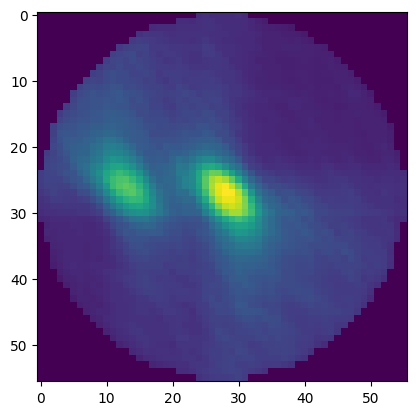

In [308]:
composite = np.ones_like(rotated_data[0])
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)

In [286]:
from findpeaks import findpeaks

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Fin.


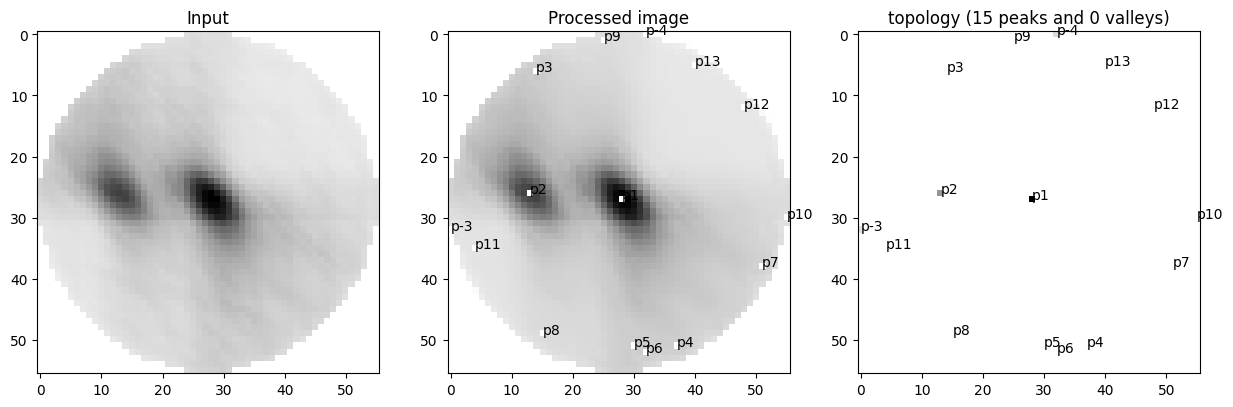

(<AxesSubplot:title={'center':'Input'}>,
 <AxesSubplot:title={'center':'Processed image'}>,
 <AxesSubplot:title={'center':'topology (15 peaks and 0 valleys)'}>)

In [287]:
fp = findpeaks(method='topology')
results = fp.fit(normalized)
fp.plot()

In [288]:
results['persistence'].head()

,x,y,birth_level,death_level,score,peak,valley
0,28,27,255.0,0.0,255.0,True,False
1,13,26,191.0,85.0,106.0,True,False
2,14,6,57.0,54.0,3.0,True,False
3,37,51,52.0,50.0,2.0,True,False
8,25,1,37.0,36.0,1.0,True,False


Using the findpeaks package, we can create a function that automatically identify feature location and with resolution uncertainty according to Poisson counting statistics.

In [289]:
def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    pfcov = cov[0,1]
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def gaussianfunc_bg(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[3]


def featureIdentification(norm_array,x,x_coord,y_coord):
    yx=norm_array[y_coord]
    dyx=np.sqrt(yx)
    x_guess=np.array([2*yx[x_coord],x_coord/2,2,10])

    yy=norm_array[x_coord]
    dyy=np.sqrt(yy)
    y_guess=np.array([2*yy[y_coord],y_coord/2,2,10])

    xmin_value,xmax_value=x_coord-6, x_coord+6
    ymin_value,ymax_value=y_coord-6, y_coord+6

    x_pf, x_pferr, x_chisq, x_dof = data_fit(x_guess, gaussianfunc_bg, x[xmin_value:xmax_value], yx[xmin_value:xmax_value], dyx[xmin_value:xmax_value])
    y_pf, y_pferr, y_chisq, y_dof = data_fit(y_guess, gaussianfunc_bg, x[ymin_value:ymax_value], yy[ymin_value:ymax_value], dyy[ymin_value:ymax_value])

    print(' ')
    print('===============================================')
    print('Feature identified at ({:.2f} +- {:.2f},{:.2f} +- {:.2f}) cm'.format(x_pf[1],x_pferr[1],y_pf[1],y_pferr[1]) )

In [290]:
x = []
step = 0.5
while step <= 28:
    x.append(step)
    step += 0.5

x = np.array(x)
x

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. ])

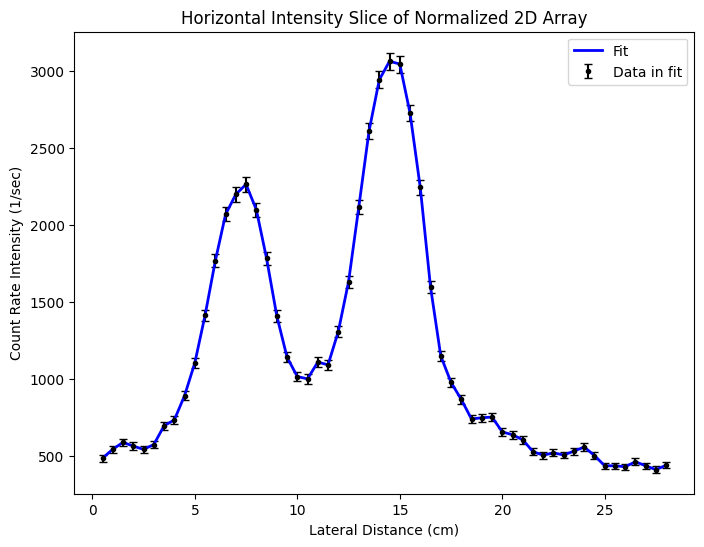

In [291]:
y = normalized[27]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Horizontal Intensity Slice of Normalized 2D Array')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()

plt.savefig('2source-horizontal.png')

In [292]:
xcoord = results['persistence'].iloc[0]['x']
ycoord = results['persistence'].iloc[0]['y']

featureIdentification(normalized,x,xcoord,ycoord)


Converged with chi-squared 34.25
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 4.28

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 6.132e+03                | 8.286e+03                | 4.592e+02               
1           | 1.400e+01                | 1.450e+01                | 1.710e-02               
2           | 2.000e+00                | 1.399e+00                | 4.815e-02               
3           | 1.000e+01                | 7.911e+02                | 6.585e+01               

Converged with chi-squared 27.72
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 3.46

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 5.596e+03                | 7.432e+03                | 2.309e+02               
1           | 1.350e+01                | 1.481e+01                | 2.101e-02               
2           | 2.000e+00     

In [293]:
xcoord = results['persistence'].iloc[1]['x']
ycoord = results['persistence'].iloc[1]['y']

featureIdentification(normalized,x,xcoord,ycoord)


Converged with chi-squared 5.66
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 0.71

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 4.605e+03                | 6.135e+03                | 4.720e+02               
1           | 6.500e+00                | 6.994e+00                | 2.170e-02               
2           | 2.000e+00                | 1.455e+00                | 6.686e-02               
3           | 1.000e+01                | 6.572e+02                | 6.645e+01               

Converged with chi-squared 7.17
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 0.90

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.236e+03                | 4.759e+03                | 7.649e+03               
1           | 1.300e+01                | 1.212e+01                | 2.089e-01               
2           | 2.000e+00       

Text(0, 0.5, 'Distance (cm)')

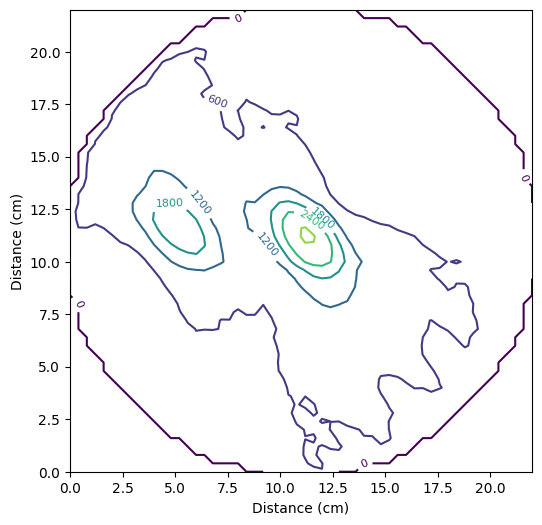

In [294]:
fig, ax = plt.subplots(figsize = (6,6))

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y)

num_lines = 5
flipped = normalized[::-1] 

p = ax.contour(X, Y, flipped,num_lines)
ax.clabel(p, inline=True, fontsize=8)
ax.set_aspect('equal')
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Distance (cm)")

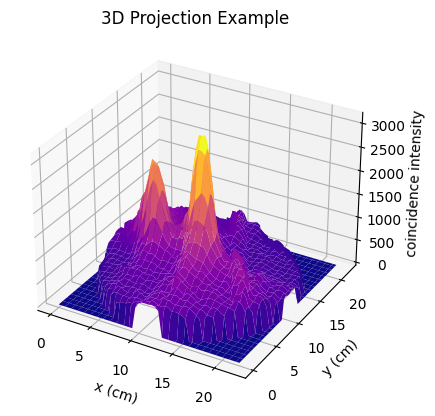

In [267]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot

ax.plot_surface(X, Y, flipped,cmap='plasma') #color maps are not required
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('coincidence intensity')
ax.set_title('3D Projection Example');